In [1]:
import pickle
import numpy

import pandas
import json
import os

%matplotlib widget
import matplotlib
import matplotlib.pyplot

import datetime
import pytz
import scipy.signal

In [2]:
# General settings

source_computer = 'beetle'
RECALCULATION_FLAG = False
root_path = '/Users/matthieu/.ssh/ssh_to_graz/saved_graz_data/' + source_computer + '/'

config_path         = root_path + 'config/'
activities_path     = root_path + 'acts/'
leds_path           = root_path + 'leds/'
metadata_path       = root_path + 'metadata/'
actuation_path      = root_path + 'actuation/'

time_of_interest = pytz.utc.localize(datetime.datetime(2023,7,23,6,0,0))
analysis_duration = 12 # in hours

In [3]:
# Experiments times
with open(config_path+'comb_config.json', "r") as f:
    exp_configuration = json.load(f)

exp_configs = [[]]*len(exp_configuration['experiment']['timeslots'])
for conf_id, conf in enumerate(exp_configuration['experiment']['timeslots']):
    exp_config = conf
    exp_config['dtts_start'] = datetime.datetime.fromisoformat(conf["from"])
    exp_config['dtts_stop'] = datetime.datetime.fromisoformat(conf["to"])
    if (exp_config['dtts_start'] >= time_of_interest and exp_config['dtts_start'] < time_of_interest+datetime.timedelta(hours=analysis_duration) or exp_config['dtts_stop'] >= time_of_interest and exp_config['dtts_stop'] < time_of_interest+datetime.timedelta(hours=analysis_duration)):
        exp_configs[conf_id] = exp_config
exp_configs = [xp for xp in exp_configs if not(xp == [])]

exp_signal = {'local_ts':[], 'value':[]}
for exp in exp_configs:
    if exp['rule'] == 'vibrate':
        exp_signal['local_ts'].append(exp['dtts_start'])
        # exp_signal['local_ts'].append(exp['dtts_start']+datetime.timedelta(seconds=1))
        exp_signal['local_ts'].append(exp['dtts_stop'])
        # exp_signal['local_ts'].append(exp['dtts_stop']+datetime.timedelta(seconds=1))
        # exp_signal['value'].append(0)
        exp_signal['value'].append(1)
        # exp_signal['value'].append(1)
        exp_signal['value'].append(0)

exp_signal['value'] = [x for _, x in sorted(zip(exp_signal['local_ts'], exp_signal['value']))]
exp_signal['local_ts'] = sorted(exp_signal['local_ts'])

exp_signal = pandas.DataFrame.from_dict(exp_signal)


In [4]:
# Activity (takes 1m10s for a day of data with current for (pandas df concat --> not very efficient))
activities = dict.fromkeys(list(range(8))+['a'])
for fid, f in enumerate(sorted(os.listdir(activities_path))):
    if not(f.endswith('.pickle')):
        continue
    time_of_exp = pytz.utc.localize(datetime.datetime.strptime(f.split('_')[0], "%y%m%dT%H%M%S%Z"))
    if (time_of_exp >= time_of_interest and time_of_exp < time_of_interest+datetime.timedelta(hours=analysis_duration)):
        zone = f.split('_')[1][1:]
        try : 
            zone = int(zone)
        except :
            zone='a'
        activities[zone] = pandas.concat([activities[zone], pandas.read_pickle(activities_path + f)], ignore_index=True)

In [5]:
# Actuation LEDs (takes 2s for a day of data with current for (pandas df concat --> not very efficient))
leds = [None]
for fid, f in enumerate(sorted(os.listdir(leds_path))):
    if not(f.endswith('.pickle')):
        continue
    time_of_exp = pytz.utc.localize(datetime.datetime.strptime(f.split('_')[0], "%y%m%dT%H%M%S%Z"))
    if (time_of_exp >= time_of_interest and time_of_exp < time_of_interest+datetime.timedelta(hours=analysis_duration)):
        leds = [pandas.concat([leds[0], pandas.read_pickle(leds_path + f)], ignore_index=True)]
leds = leds[0]
         

In [6]:
# Metadata
metadata = None
for fid, f in enumerate(sorted(os.listdir(metadata_path))):
    if not(f.endswith('.pickle')):
        continue
    time_of_exp = pytz.utc.localize(datetime.datetime.strptime(f.split('.')[0].split('_waggles20')[-1], "%y%m%d"))
    if (time_of_exp.date() == time_of_interest.date()):
        metadata = pandas.read_pickle(metadata_path + f)

In [7]:
# Actuation commands
actuation_df = None
for fid, f in enumerate(sorted(os.listdir(actuation_path))):
    if not(f.endswith('.pickle')):
        continue
    actuation_df = pandas.read_pickle(actuation_path + f)
actuation = None
for exp_id, exp in enumerate(exp_configs):
    actuation = pandas.concat([actuation, actuation_df[actuation_df.ts_start == exp['dtts_start']]], ignore_index=True)

acttimes    = []
actsig      = []
for act_id, act in actuation.iterrows():
    acttimes += act.sbtimes
    actsig += act.on_off
# print(acttimes)
# acttimes = acttimes[0]
# print(acttimes)
# actsig = actsig[0]
actsig = [x for _, x in sorted(zip(acttimes, actsig))]
acttimes = sorted(acttimes)

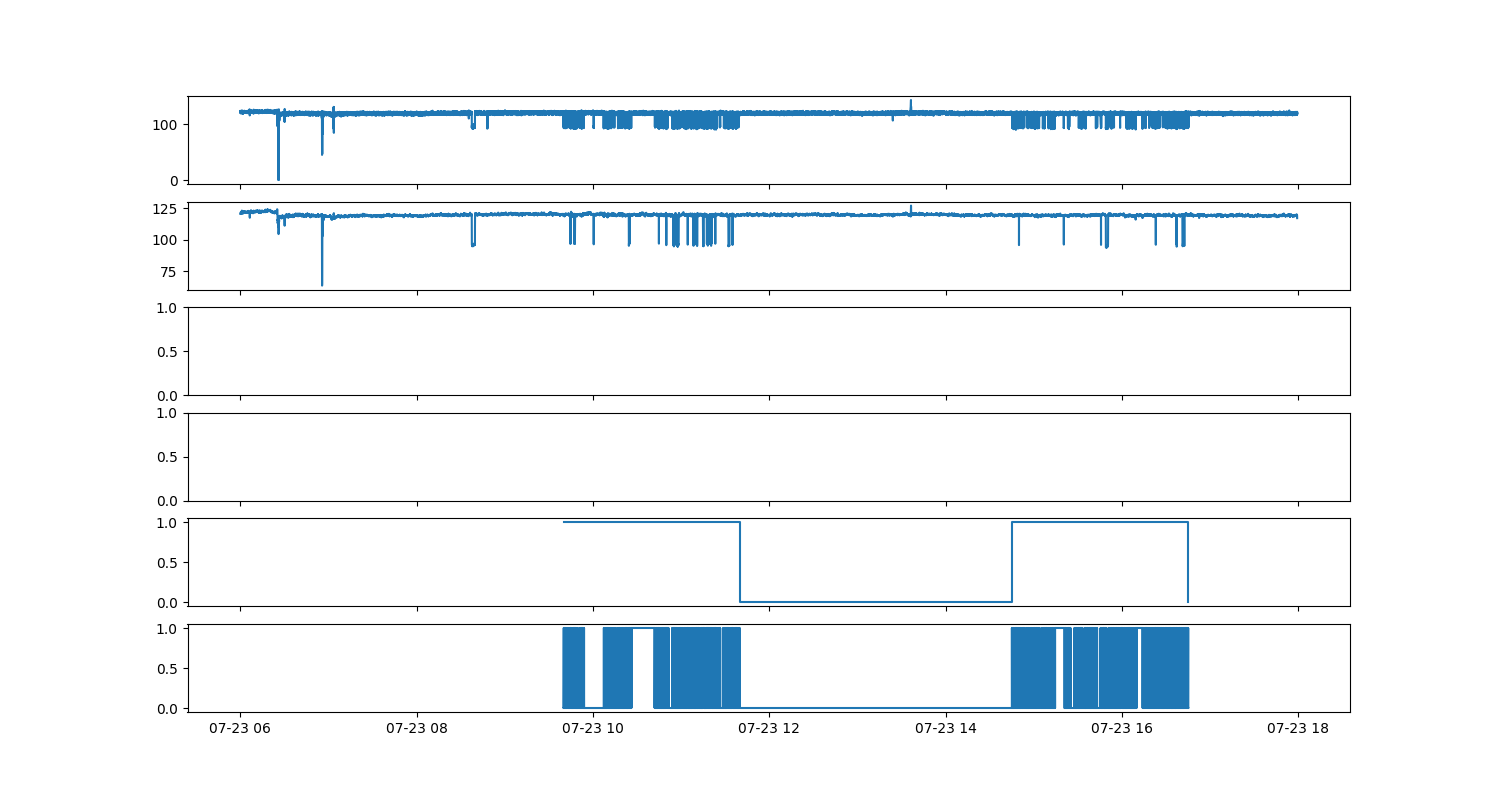

In [8]:
fig, ax = matplotlib.pyplot.subplots(6, 1, figsize=(15,8), sharex=True)
ax[0].plot(leds.local_ts, leds.value)
ax[1].plot(leds.local_ts, scipy.signal.medfilt(leds.value, 301))
ax[4].step(exp_signal.local_ts, exp_signal.value, where='post')
ax[5].step(acttimes, actsig, where='post')
# ax[1].plot(activities[2].local_ts, activities[2].value, '--b', linewidth=.5)
# ax[2].plot(activities[3].local_ts, activities[3].value, '--r', linewidth=.5)
# ax[3].plot(activities[4].local_ts, activities[4].value, '--g', linewidth=.5)

In [9]:
exp_signal.value

0    1
1    0
2    1
3    0
Name: value, dtype: int64

In [10]:
exp_signal.local_ts

0   2023-07-23 11:40:00+02:00
1   2023-07-23 13:40:00+02:00
2   2023-07-23 16:45:00+02:00
3   2023-07-23 18:45:00+02:00
Name: local_ts, dtype: datetime64[ns, UTC+02:00]

In [11]:
actuation.head(10)

,ts_start,ts_stop,sb0,sb1,sbtimes,on_off,ratio,actuation_durations
0,2023-07-23 11:40:00+02:00,2023-07-23 13:40:00+02:00,"[11, 0, 11, 0, 0, 11, 1, 0, 11, 11, 0, 0, 1, 1...","[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1...","[2023-07-23 11:40:00+02:00, 2023-07-23 09:40:0...","[0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, ...",0.333517,"{'on': 2401.3246229999977, 'off': 4798.6753769..."
1,2023-07-23 16:45:00+02:00,2023-07-23 18:45:00+02:00,"[11, 11, 11, 11, 1, 1, 11, 11, 11, 0, 11, 0, 1...","[11, 0, 0, 11, 11, 0, 0, 0, 11, 11, 11, 11, 11...","[2023-07-23 16:45:00+02:00, 2023-07-23 14:45:0...","[0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, ...",0.294653,"{'on': 2121.498569, 'off': 5078.501431000001}"


In [12]:
len(acttimes)

2931

In [13]:
activities

{0:                                 local_ts global_ts        event_type origin  \
 0       2023-07-23 07:00:00.033333+00:00      None  LEDs intensities   rpi4   
 1       2023-07-23 07:00:00.066667+00:00      None  LEDs intensities   rpi4   
 2       2023-07-23 07:00:00.100000+00:00      None  LEDs intensities   rpi4   
 3       2023-07-23 07:00:00.133333+00:00      None  LEDs intensities   rpi4   
 4       2023-07-23 07:00:00.166667+00:00      None  LEDs intensities   rpi4   
 ...                                  ...       ...               ...    ...   
 1063735 2023-07-23 16:59:05.733333+00:00      None  LEDs intensities   rpi4   
 1063736 2023-07-23 16:59:05.766667+00:00      None  LEDs intensities   rpi4   
 1063737 2023-07-23 16:59:05.800000+00:00      None  LEDs intensities   rpi4   
 1063738 2023-07-23 16:59:05.833333+00:00      None  LEDs intensities   rpi4   
 1063739 2023-07-23 16:59:05.866667+00:00      None  LEDs intensities   rpi4   
 
                                   

In [14]:
len(activities[3])

1063740